# Retrieve Snow Denisties and Plot

retrieve densitities within pits and plot against ? (grain size? hardness? depth?)

## Retrieve Snow Denisties From SnowEx SQL Database


https://snowex-hackweek.github.io/website/tutorials/microstructure/microstructure-tutorial.html

In [468]:
# Modules needed to access snowexsql: SnowEx field data database
from snowexsql.db import get_db
from snowexsql.data import SiteData, PointData, LayerData, ImageData
from snowexsql.conversions import points_to_geopandas, query_to_geopandas

# Modules needed to work with data
import geoalchemy2.functions as gfunc
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import plot_confusion_matrix


#note - this cell does not return any output

Example

In [469]:
# Import the class reflecting the points table in the db
from snowexsql.data import LayerData

# Import the function to investigate a table
from snowexsql.db import get_table_attributes

# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(LayerData)

# Print out the results nicely
print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))


These are the available columns in the table:
 
* bottom_depth
* comments
* date
* date_accessed
* depth
* doi
* easting
* elevation
* geom
* instrument
* latitude
* longitude
* metadata
* northing
* sample_a
* sample_b
* sample_c
* site_id
* site_name
* surveyors
* time
* time_created
* time_updated
* type
* units
* utm_zone
* value



### hand hardness

In [470]:
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

# Grab all the equivalent diameter profiles
q = session.query(LayerData).filter(LayerData.type == 'hand_hardness')
hhardness_df = query_to_geopandas(q, engine)

# End our database session to avoid hanging transactions
session.close()

# density_df.head() #check out the results of the query

In [471]:
hhardness_filter_df = hhardness_df[['site_id','depth','value']].copy()

In [472]:
hhardness_filter_df = hhardness_filter_df.rename(columns={"value": "hhardness"})

## clean up density data

### download density data from database

In [473]:
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

# Grab all the equivalent diameter profiles
q = session.query(LayerData).filter(LayerData.type == 'density')
density_df = query_to_geopandas(q, engine)

# End our database session to avoid hanging transactions
session.close()

# density_df.head() #check out the results of the query

In [474]:
# convert data formats from "object" to workable formats
density_df['depth'] = density_df['depth'].astype(float)
density_df['value'] = density_df['value'].astype(float)
density_df['latitude'] = density_df['latitude'].astype(float)

# rename density column for clarity
# rename the density column for clarity
density_df = density_df.rename(columns={"value": "density"})


In [475]:
# filter the dataframe for the desired columns
density_filter_df = density_df[['site_id','latitude', 'longitude','depth','bottom_depth','density']].copy()

In [64]:
# # check the data for a site to see what we're working with, we'll use site 1C1 as an example
# density_filter_df[density_filter_df.site_id == '1C1'] # list the values of the dataframe where the site_id is equal to 1C1

Oh no! It looks like for each density measurement, there is a unique row. This means we have redundant average densities (i.e. the value in the 'value' column) for some depths. 
Let's filter this data so that we only have one density for each depth within each pit

In [476]:
# list the unique site id values in the dataframe
site_id_unique = density_filter_df['site_id'].unique()

In [477]:
# for each of the unique site_id's, go to where the "site_id" column in the dataframe is equal to that site id. from there drop redundant depth values, and reassign the site id column to the newly filtered set of values
for site_num in range(site_id_unique.size):
    density_filter_df[density_filter_df.site_id == site_id_unique[site_num]] = density_filter_df[density_filter_df.site_id == site_id_unique[site_num]].drop_duplicates(subset='depth', keep="last")
# because we aren't telling the dataframe to delete those rows, they return as nans
# drop NaN values
density_filter_df = density_filter_df.dropna(subset=['site_id','depth','density'])
density_filter_df = density_filter_df.reset_index(drop=True)

In [ ]:
# # uncomment to check results
# density_filter_df

### download site data from database
this is a little bit cleaner because there is only one value per pit

In [478]:
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

# Grab all the equivalent diameter profiles
q = session.query(SiteData)
siteData_df = query_to_geopandas(q, engine)

# End our database session to avoid hanging transactions
session.close()

#siteData_df.head() #check out the results of the query

In [479]:
# filter for the values we want
siteData_filter_df = siteData_df[['site_id','tree_canopy']].copy()

In [52]:
# # uncomment to check results
# siteData_filter_df

### merge the two dataframes based on the site_id column and sort based on site_id and depth

In [480]:
# create a merged dataframe
merged_df = density_filter_df.merge(siteData_filter_df, left_on='site_id', right_on='site_id')

# sort values so that we can determine top 10 and 50 cm from each pit
merged_df = merged_df.sort_values(by=['site_id', 'depth'],ascending=False)

In [481]:
# for each of the unique site_id's, go to where the "site_id" column in the dataframe is equal to that site id. from there drop redundant depth values, and reassign the site id column to the newly filtered set of values
for site_num in range(site_id_unique.size):
    merged_df[merged_df.site_id == site_id_unique[site_num]] = merged_df[merged_df.site_id == site_id_unique[site_num]].drop_duplicates(subset='depth', keep="last")

In [482]:
merged_df.density[merged_df.density < 50] = np.nan
merged_df = merged_df.dropna(subset=['site_id','depth','density'])
merged_df = merged_df.reset_index(drop=True)
#merged_df = merged_df.drop(columns=['bottom_depth','sample_a','sample_b','sample_c']) # comment out if you want to see which sites have multiple measurements

In [483]:
densityAgg_df = merged_df.groupby('site_id').agg({'density': ['mean']})
densityAgg_df = densityAgg_df.rename(columns={'density': "avg_total"})
densityAgg_df = densityAgg_df.reset_index()

max depth per site - 10, ma

### create new dataframes with upper 10 and 50 cm depths for each profile

### upper 50 cm

In [484]:
#create a copy of the merged dataframe 
merged_top50_df = merged_df.copy()

In [485]:
# we want the top 50 cm
for site_num in range(site_id_unique.size):
    merged_top50_df[merged_top50_df.site_id == site_id_unique[site_num]] = merged_top50_df[merged_top50_df.site_id == site_id_unique[site_num]].head(5)
    
merged_top50_df.reset_index();

In [486]:
# drop all nans
merged_top50_df = merged_top50_df.dropna(subset=['site_id','depth','density'])

In [487]:
top50_densityAgg_df = merged_top50_df.groupby('site_id').agg({'density': ['mean']})
top50_densityAgg_df = top50_densityAgg_df.rename(columns={'density': "avg_50"})
top50_densityAgg_df = top50_densityAgg_df.reset_index()
#top50_densityAgg_df = merged_df.groupby('site_id').agg({'depth': ['max']})

### upper 10 cm

In [488]:
#create a copy of the merged dataframe 
merged_top10_df = merged_df.copy()

# we want the top 50 cm
for site_num in range(site_id_unique.size):
    merged_top10_df[merged_top10_df.site_id == site_id_unique[site_num]] = merged_top10_df[merged_top10_df.site_id == site_id_unique[site_num]].head(1)
# drop all nans
merged_top10_df = merged_top10_df.dropna(subset=['site_id','depth','density'])  
merged_top10_df.reset_index();


## merge final calculations into dataframe

In [636]:
density_final_df = merged_top10_df.merge(top50_densityAgg_df, on = 'site_id')
density_final_df = density_final_df.merge(densityAgg_df, on = 'site_id')

In [637]:
density_final_df = density_final_df.rename(columns={('avg_50','mean'): "density_avg50", 'density':'density_avg10',('avg_total','mean'): "density_avgTotal"})

## Filter desired pits

7C15
8C11
8N38
9C16
9C17
2C12
5N10
5N19
5S43
8N25
9S51
1N23
1S8
2S11
5N11
5N15

In [491]:
# create a list with the desired site_ids
site_list = ['7C15', '8C11', '8N38', '9C16', '9C17', '2C12', '5N10', '5N19', '5S43', '8N25', '9S51', '1N23', '1S8', '2S11', '5N11', '5N15']

In [638]:
density_final_fil_df = density_final_df[density_final_df['site_id'].isin(site_list)]
density_final_fil_df = density_final_fil_df.reset_index(drop = True)
density_final_fil_df = density_final_fil_df.sort_values(['site_id'], ascending = (False))


merged_top10_fil_df = merged_top10_df[merged_top10_df['site_id'].isin(site_list)]
merged_top10_fil_df = merged_top10_fil_df.reset_index(drop = True)

densityAgg_fil_df = densityAgg_df[densityAgg_df['site_id'].isin(site_list)]
densityAgg_fil_df = densityAgg_fil_df.reset_index(drop = True)

top50_densityAgg_fil_df = top50_densityAgg_df[top50_densityAgg_df['site_id'].isin(site_list)]
top50_densityAgg_fil_df = top50_densityAgg_fil_df.reset_index(drop = True)
merged_top50_fil_df = merged_top50_df[merged_top50_df['site_id'].isin(site_list)]
merged_top50_fil_df = merged_top50_fil_df.reset_index(drop = True)

merged_fil_df = merged_df[merged_df['site_id'].isin(site_list)]
merged_fil_df = merged_fil_df.reset_index(drop = True)

hhardness_filSites_df = hhardness_filter_df[hhardness_filter_df['site_id'].isin(site_list)]
hhardness_filSites_df = hhardness_filSites_df.reset_index(drop = True)


## manual canopy and smp

## CFE

In [639]:
CFE_df = pd.read_csv('/home/jovyan/snow-sinking/data/CFE.csv')

In [640]:
CFE_canopy = np.array(['dense','open','dense','dense','open','open','open','sparse','open','open','open','open','open','dense','dense','dense',])
CFE_df['CFE_canopy'] = CFE_canopy

In [641]:
CFE_df = CFE_df[['Site','CFE_canopy']].copy()
CFE_df = CFE_df.rename(columns={'Site':'site_id'})

In [642]:
CFE_df = CFE_df.sort_values(['site_id'], ascending = (False),ignore_index = True)

In [643]:
# load canopy csv
canopy_manual_df = pd.read_csv('/home/jovyan/snow-sinking/selected_sites_canopy.csv')
# change column names for clarity
canopy_manual_df = canopy_manual_df.rename(columns={'Canopy Type  photos ':'canopy', 'Site':'site_id'})
# filter desired columns
canopy_manual_df = canopy_manual_df[['site_id','canopy']].copy()

In [644]:
# reclassify pit canopy classes
tree_reclass_df = density_final_df[['site_id','tree_canopy']].copy()
tree_reclass_df = tree_reclass_df.rename(columns={'tree_canopy':'db_canopy_reclass'})

In [645]:
# reclassify data
tree_reclass_df.db_canopy_reclass[tree_reclass_df.db_canopy_reclass == 'Closed (>70%)'] = 'dense'
tree_reclass_df.db_canopy_reclass[tree_reclass_df.db_canopy_reclass == 'Open (20-70%)'] = 'open'
tree_reclass_df.db_canopy_reclass[tree_reclass_df.db_canopy_reclass == 'Sparse (5-20%)'] = 'sparse'
tree_reclass_df.db_canopy_reclass[tree_reclass_df.db_canopy_reclass == 'No Trees'] = 'open'

In [646]:
#clean up data
canopy_manual_df.canopy[canopy_manual_df.canopy == 'Dense (pine)'] = 'dense'
canopy_manual_df.canopy[canopy_manual_df.canopy == 'Sparse (pine/aspen)'] = 'sparse'
canopy_manual_df.canopy[canopy_manual_df.canopy == 'Sparse (pine/ aspen)'] = 'sparse'
canopy_manual_df.canopy[canopy_manual_df.canopy == 'Sparse (pine)'] = 'sparse'
canopy_manual_df.canopy[canopy_manual_df.canopy == 'Sparse (aspen)'] = 'sparse'
canopy_manual_df.canopy[canopy_manual_df.canopy == 'Sparse (aspen) '] = 'sparse'
canopy_manual_df.canopy[canopy_manual_df.canopy == 'Sparse (pine/ aspem)'] = 'sparse'
canopy_manual_df.canopy[canopy_manual_df.canopy == 'Sparse (pine) '] = 'sparse'

In [647]:
canopy_all_df = canopy_manual_df.merge(tree_reclass_df, left_on='site_id', right_on='site_id')
canopy_all_df = canopy_all_df.merge(CFE_df, left_on='site_id', right_on='site_id')
canopy_all_df = canopy_all_df.rename(columns={'canopy':'photo canopy','db_canopy_reclass':'field canopy'})
canopy_all_df = canopy_all_df.sort_values(['site_id'], ascending = (False),ignore_index = True)

canopy_all_df_nosite = canopy_all_df.drop(['site_id'], axis=1)
canopy_all_df_nosite = pd.melt(canopy_all_df_nosite)
repeat_canopy_df = canopy_all_df_nosite.copy()
repeat_canopy_df['site_id'] = (pd.concat([canopy_all_df.site_id] *3)).values
repeat_canopy_df = repeat_canopy_df.rename(columns={'variable':'canopy_method','value':'canopy_class'})

In [648]:
# add other metrics
repeat_canopy_df['density_avg10'] = (pd.concat([density_final_fil_df.density_avg10] *3)).values
repeat_canopy_df['density_avg50'] = (pd.concat([density_final_fil_df.density_avg50] *3)).values
repeat_canopy_df['density_avgTotal'] = (pd.concat([density_final_fil_df.density_avgTotal] *3)).values
repeat_canopy_df['depth'] = (pd.concat([density_final_fil_df.depth] *3)).values

In [649]:
# # create a confusion matrix
# canopy_confusion = confusion_matrix(canopy_all_df.db_canopy_reclass, canopy_all_df.canopy, labels=["dense", "sparse", "open"])

In [650]:
#merge with final dataframe
density_final_df = density_final_df.merge(canopy_manual_df, left_on='site_id', right_on='site_id')
density_final_df = density_final_df.merge(tree_reclass_df, left_on='site_id', right_on='site_id')


## smp data

In [651]:
# load canopy csv
smp_df = pd.read_csv('/home/jovyan/snow-sinking/SMP_data_with_mean.csv')
# change column names for clarity
smp_df = smp_df.rename(columns={'siteID':'site_id','med_force':'smp_med', 'sum10':'smp_sum10','sum50':'smp_sum50','mean':'smp_mean'})
# filter desired columns
smp_df = smp_df[['site_id','smp_sum10','smp_sum50','smp_mean']].copy()

In [652]:
density_final_df = density_final_df.merge(smp_df, left_on='site_id', right_on='site_id')

In [656]:
smp_df = smp_df.sort_values(['site_id'], ascending = (False),ignore_index = True)
repeat_canopy_df['smp_mean'] = (pd.concat([smp_df.smp_mean] *3)).values
repeat_canopy_df['smp_sum10'] = (pd.concat([smp_df.smp_sum10] *3)).values
repeat_canopy_df['smp_sum50'] = (pd.concat([smp_df.smp_sum50] *3)).values

## modeled

In [657]:
model_dense = pd.read_csv('/home/jovyan/snow-sinking/data/modeled_sden/modeled_sden_dense.csv')
model_open = pd.read_csv('/home/jovyan/snow-sinking/data/modeled_sden/modeled_sden_open.csv')
model_sparse = pd.read_csv('/home/jovyan/snow-sinking/data/modeled_sden/modeled_sden_sparse.csv')


In [658]:
model_dense['canopy_class'] = 'dense'
model_dense = model_dense.rename(columns={'snow density (dense)':'density'})

model_open['canopy_class'] = 'open'
model_open = model_open.rename(columns={'snow density (open)':'density'})

model_sparse['canopy_class'] = 'sparse'
model_sparse = model_sparse.rename(columns={'snow density (sparse)':'density'})


In [659]:
model_all = pd.concat([model_dense, model_open,model_sparse])

## Plot

#### Summary Stats (histograms)

Text(0.5, 0, 'Density (kg/m3)')

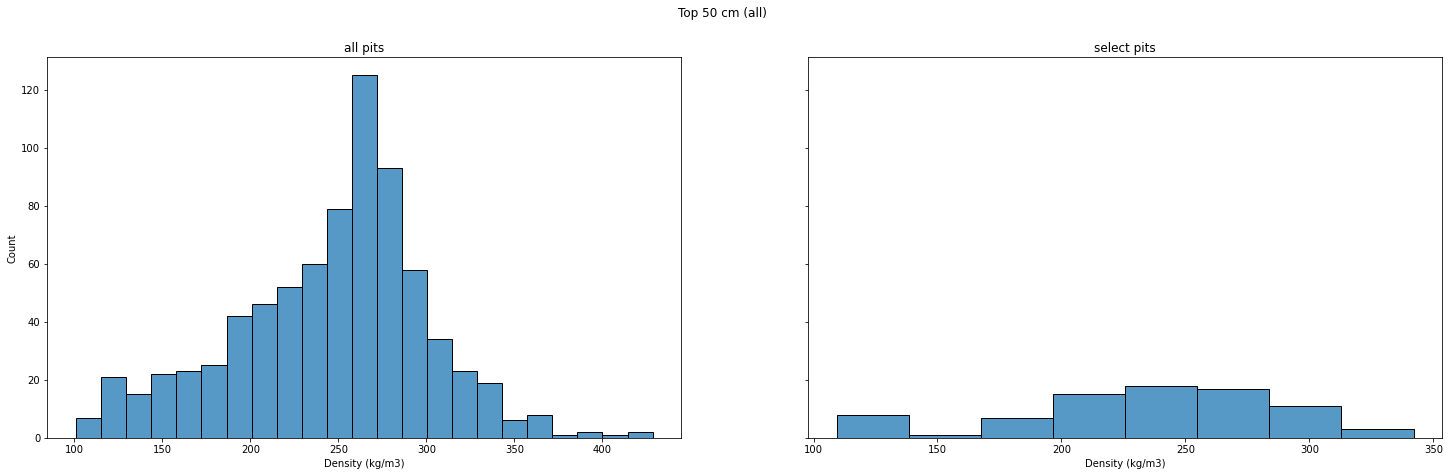

In [147]:
#createa a figure axis
fig, axes = plt.subplots(1, 2, figsize=(25, 7), sharey=True)
fig.suptitle('Top 50 cm (all)')

sns.histplot(ax= axes[0],data=merged_top50_df, x="density");
axes[0].set_title('all pits')
axes[0].set_xlabel('Density (kg/m3)')
sns.histplot(ax= axes[1],data=merged_top50_fil_df, x="density");
axes[1].set_title('select pits')
axes[1].set_xlabel('Density (kg/m3)')


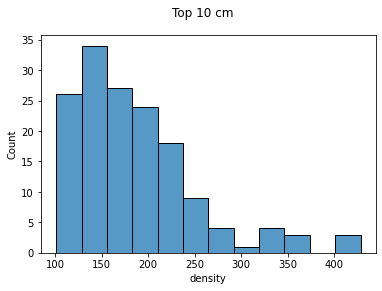

In [82]:
fig, ax = plt.subplots()
fig.suptitle('Top 10 cm')
sns.histplot(data=merged_top10_df, x="density");

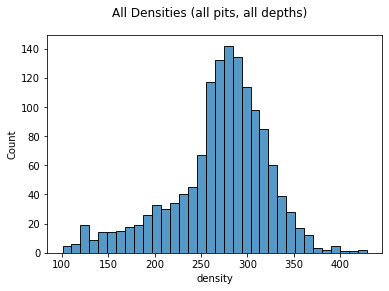

In [83]:
fig, ax = plt.subplots()
fig.suptitle('All Densities (all pits, all depths)')
sns.histplot(data=merged_df, x="density");

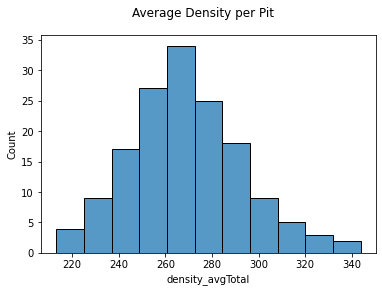

In [86]:
fig, ax = plt.subplots()
fig.suptitle('Average Density per Pit')
sns.histplot(data=density_final_df, x="density_avgTotal");

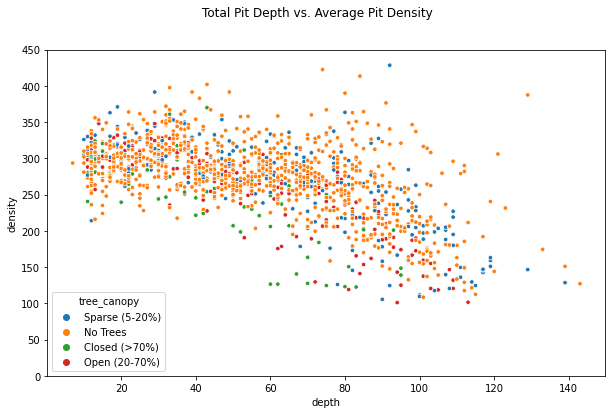

In [151]:
fig, ax = plt.subplots(1, figsize=(10, 6), sharey=True)
fig.suptitle('Total Pit Depth vs. Average Pit Density')

sns.scatterplot(ax=ax, x=merged_df.depth, y=merged_df.density,marker = '.',s = 80,hue = merged_df.tree_canopy)
ax.set(ylim=(0, 450));

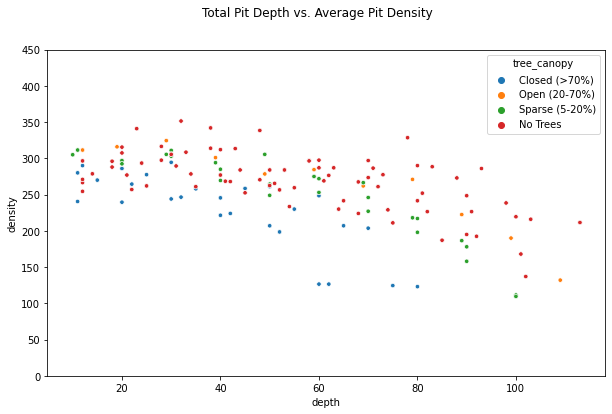

In [150]:
fig, ax = plt.subplots(1, figsize=(10, 6), sharey=True)
fig.suptitle('Total Pit Depth vs. Average Pit Density')

sns.scatterplot(ax=ax, x=merged_fil_df.depth, y=merged_fil_df.density,marker = '.',s = 80,hue = merged_fil_df.tree_canopy)
ax.set(ylim=(0, 450));

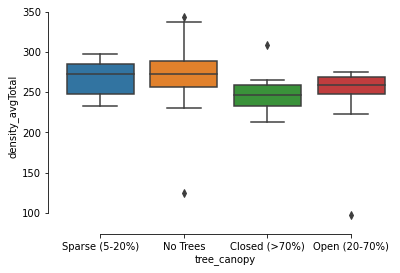

In [492]:
sns.boxplot(x="tree_canopy", y="density_avgTotal",
            data=density_final_df)
sns.despine(offset=10, trim=True)

density

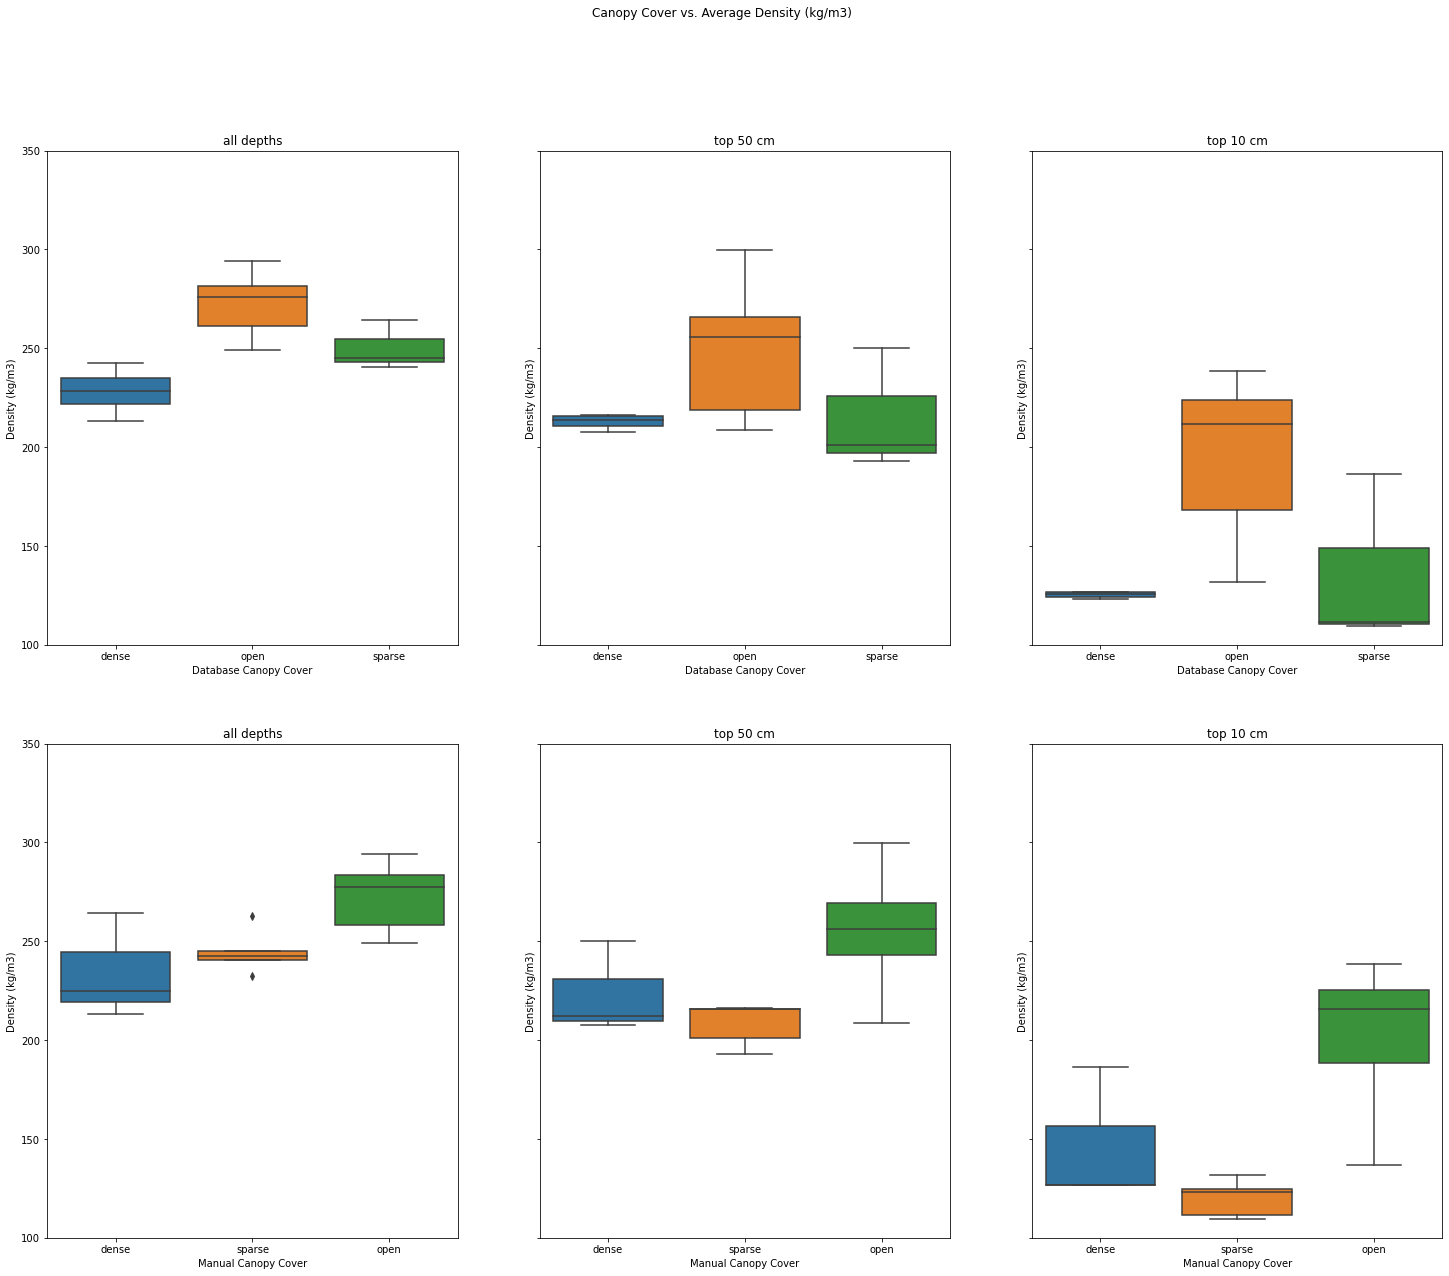

In [505]:
#createa a figure axis
fig, axes = plt.subplots(2, 3, figsize=(25, 20), sharey=True)
fig.suptitle('Canopy Cover vs. Average Density (kg/m3)')

sns.boxplot(ax=axes[0,0], x=density_final_df.db_canopy_reclass, y=density_final_df.density_avgTotal)
axes[0,0].set_title('all depths')
axes[0,0].set_xlabel('Database Canopy Cover')
axes[0,0].set_ylabel('Density (kg/m3)')
axes[0,0].set(ylim=(100, 350));

sns.boxplot(ax=axes[0,1], x=density_final_df.db_canopy_reclass, y=density_final_df.density_avg50)
axes[0,1].set_title('top 50 cm')
axes[0,1].set_xlabel('Database Canopy Cover')
axes[0,1].set_ylabel('Density (kg/m3)')
axes[0,1].set(ylim=(100, 350));

sns.boxplot(ax=axes[0,2], x=density_final_df.db_canopy_reclass, y=density_final_df.density_avg10)
axes[0,2].set_title('top 10 cm')
axes[0,2].set_xlabel('Database Canopy Cover')
axes[0,2].set_ylabel('Density (kg/m3)');
axes[0,2].set(ylim=(100, 350));


sns.boxplot(ax=axes[1,0], x=density_final_df.canopy, y=density_final_df.density_avgTotal)
axes[1,0].set_title('all depths')
axes[1,0].set_xlabel('Manual Canopy Cover')
axes[1,0].set_ylabel('Density (kg/m3)')
axes[1,0].set(ylim=(100, 350));

sns.boxplot(ax=axes[1,1], x=density_final_df.canopy, y=density_final_df.density_avg50)
axes[1,1].set_title('top 50 cm')
axes[1,1].set_xlabel('Manual Canopy Cover')
axes[1,1].set_ylabel('Density (kg/m3)')
axes[1,1].set(ylim=(100, 350));

sns.boxplot(ax=axes[1,2], x=density_final_df.canopy, y=density_final_df.density_avg10)
axes[1,2].set_title('top 10 cm')
axes[1,2].set_xlabel('Manual Canopy Cover')
axes[1,2].set_ylabel('Density (kg/m3)');
axes[1,2].set(ylim=(100, 350));

#fig.savefig('/home/jovyan/snow-sinking/density_files/tree_avgDensity_fig.png',dpi = 200)

In [435]:
repeat_canopy_df.columns

Index(['canopy_method', 'canopy_class', 'site_id', 'density_avg10',
       'density_avg50', 'density_avgTotal', 'depth', 'smp_med', 'smp_sum10',
       'smp_sum50'],
      dtype='object')

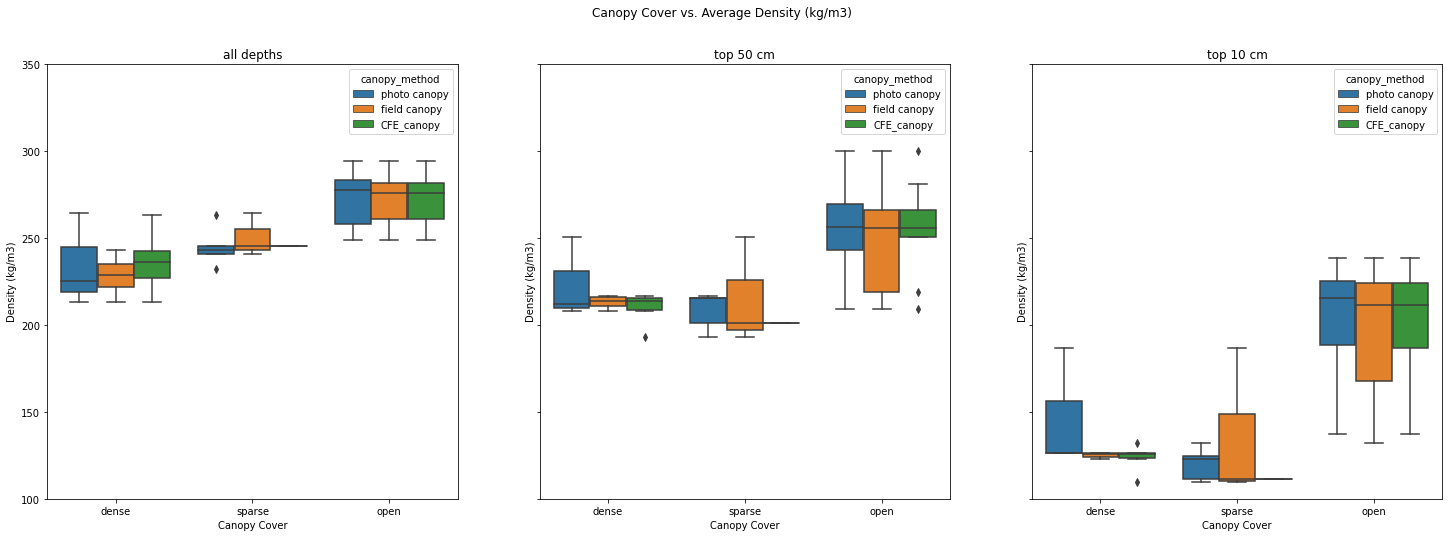

In [665]:
#createa a figure axis
fig, axes = plt.subplots(1, 3, figsize=(25, 8), sharey=True)
fig.suptitle('Canopy Cover vs. Average Density (kg/m3)')

sns.boxplot(ax=axes[0], x=repeat_canopy_df.canopy_class, y=repeat_canopy_df.density_avgTotal, hue = repeat_canopy_df.canopy_method)
axes[0].set_title('all depths')
axes[0].set_xlabel('Canopy Cover')
axes[0].set_ylabel('Density (kg/m3)')
axes[0].set(ylim=(100, 350));

sns.boxplot(ax=axes[1], x=repeat_canopy_df.canopy_class, y=repeat_canopy_df.density_avg50, hue = repeat_canopy_df.canopy_method)
axes[1].set_title('top 50 cm')
axes[1].set_xlabel('Canopy Cover')
axes[1].set_ylabel('Density (kg/m3)')
axes[1].set(ylim=(100, 350));

sns.boxplot(ax=axes[2], x=repeat_canopy_df.canopy_class, y=repeat_canopy_df.density_avg10, hue = repeat_canopy_df.canopy_method)
axes[2].set_title('top 10 cm')
axes[2].set_xlabel('Canopy Cover')
axes[2].set_ylabel('Density (kg/m3)');
axes[2].set(ylim=(100, 350));
#fig.savefig('/home/jovyan/snow-sinking/density_files/canopy_pitDensity.png',dpi = 200)

depth

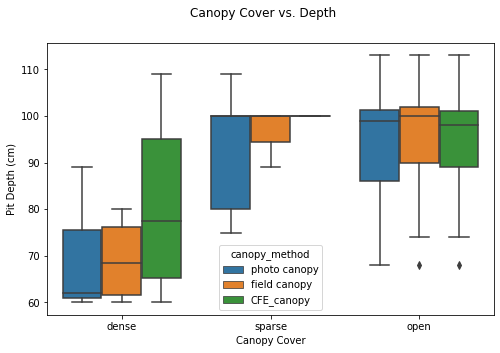

In [666]:
#createa a figure axis
fig, axes = plt.subplots(1, figsize=(8, 5), sharey=True)
fig.suptitle('Canopy Cover vs. Depth')

sns.boxplot(ax=axes, x=repeat_canopy_df.canopy_class, y=repeat_canopy_df.depth, hue = repeat_canopy_df.canopy_method)
axes.set_xlabel('Canopy Cover')
axes.set_ylabel('Pit Depth (cm)');
# axes[1].set(ylim=(100, 350));
fig.savefig('/home/jovyan/snow-sinking/density_files/canopy_depth.png',dpi = 200)

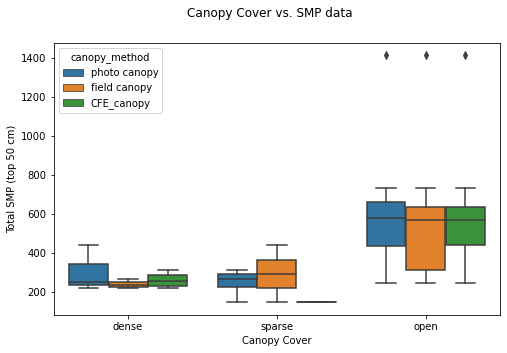

In [667]:
#createa a figure axis
fig, axes = plt.subplots(1, figsize=(8, 5), sharey=True)
fig.suptitle('Canopy Cover vs. SMP data')

sns.boxplot(ax=axes, x=repeat_canopy_df.canopy_class, y=repeat_canopy_df.smp_sum50, hue = repeat_canopy_df.canopy_method)
axes.set_xlabel('Canopy Cover')
axes.set_ylabel('Total SMP (top 50 cm)')
# axes[1].set(ylim=(100, 350));
#fig.savefig('/home/jovyan/snow-sinking/density_files/smp_top50.png',dpi = 200)

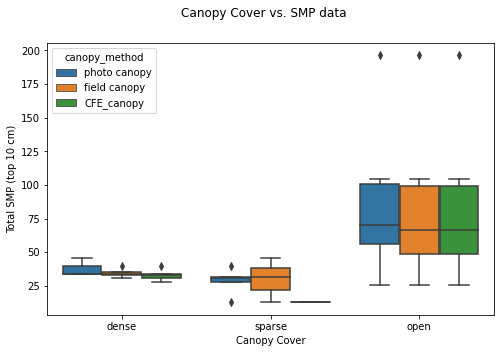

In [668]:
#createa a figure axis
fig, axes = plt.subplots(1, figsize=(8, 5), sharey=True)
fig.suptitle('Canopy Cover vs. SMP data')

sns.boxplot(ax=axes, x=repeat_canopy_df.canopy_class, y=repeat_canopy_df.smp_sum10, hue = repeat_canopy_df.canopy_method)
axes.set_xlabel('Canopy Cover')
axes.set_ylabel('Total SMP (top 10 cm)');
#fig.savefig('/home/jovyan/snow-sinking/density_files/smp_top10.png',dpi = 200)

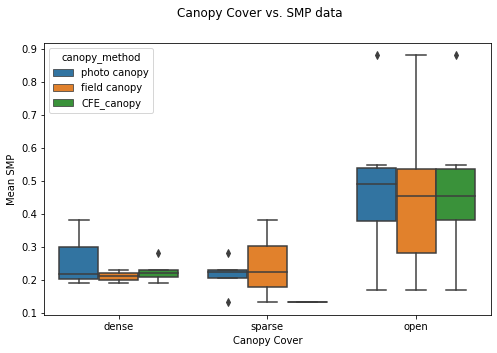

In [669]:
#createa a figure axis
fig, axes = plt.subplots(1, figsize=(8, 5), sharey=True)
fig.suptitle('Canopy Cover vs. SMP data')

sns.boxplot(ax=axes, x=repeat_canopy_df.canopy_class, y=repeat_canopy_df.smp_mean, hue = repeat_canopy_df.canopy_method)
axes.set_xlabel('Canopy Cover')
axes.set_ylabel('Mean SMP');
#fig.savefig('/home/jovyan/snow-sinking/density_files/smp_mean.png',dpi = 200)

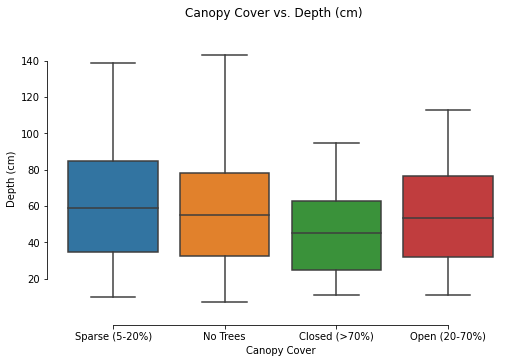

In [156]:
#createa a figure axis
fig, ax = plt.subplots(1, figsize=(8, 5), sharey=True)
fig.suptitle('Canopy Cover vs. Depth (cm)')
sns.boxplot(x="tree_canopy", y="depth",
            data=merged_df)
ax.set_xlabel('Canopy Cover')
ax.set_ylabel('Depth (cm)')
sns.despine(offset=10, trim=True)
#fig.savefig('/home/jovyan/snow-sinking/density_files/tree_depth_fig.png',dpi = 200)

model

In [527]:
model_all.columns

Index(['density', 'canopy_class'], dtype='object')

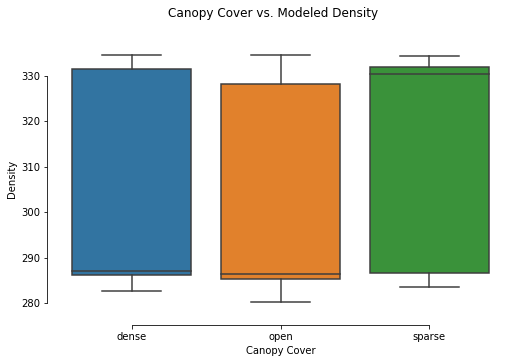

In [530]:
#createa a figure axis
fig, ax = plt.subplots(1, figsize=(8, 5), sharey=True)
fig.suptitle('Canopy Cover vs. Modeled Density')
sns.boxplot(x="canopy_class", y="density",
            data=model_all)
ax.set_xlabel('Canopy Cover')
ax.set_ylabel('Density')
sns.despine(offset=10, trim=True)
fig.savefig('/home/jovyan/snow-sinking/density_files/model_density.png',dpi = 200)

In [618]:
model_dense

,density,canopy_class
0,284.739796,dense
1,284.740527,dense
2,284.339133,dense
3,284.362607,dense
4,283.962748,dense
...,...,...
3742,286.139893,dense
3743,286.550694,dense
3744,286.530117,dense
3745,286.550589,dense


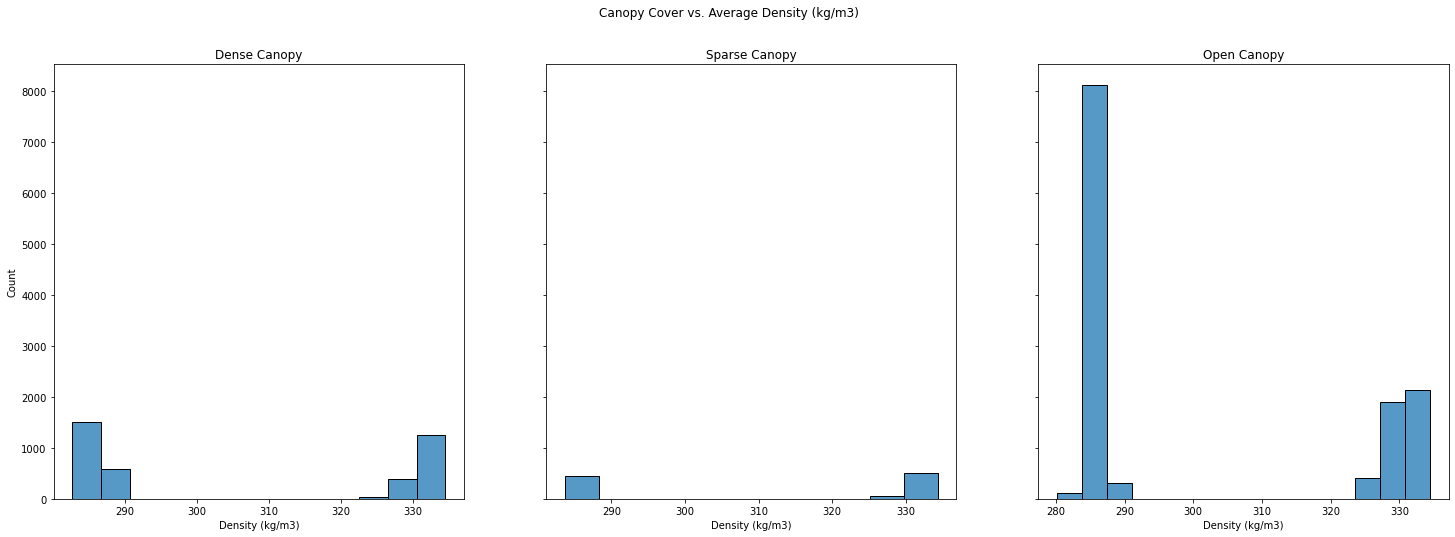

In [621]:
#createa a figure axis
fig, axes = plt.subplots(1, 3, figsize=(25, 8), sharey=True)
fig.suptitle('Canopy Cover vs. Average Density (kg/m3)')

sns.histplot(ax = axes[0], data=model_dense, x="density");
axes[0].set_title('Dense Canopy')
axes[0].set_xlabel('Density (kg/m3)')
axes[0].set_ylabel('Count')
# axes[0].set(ylim=(100, 350));

sns.histplot(ax = axes[1],data=model_sparse, x="density");
axes[1].set_title('Sparse Canopy')
axes[1].set_xlabel('Density (kg/m3)')
axes[1].set_ylabel('Count')
# axes[1].set(ylim=(100, 350));

sns.histplot(ax = axes[2], data=model_open, x="density");
axes[2].set_title('Open Canopy')
axes[2].set_xlabel('Density (kg/m3)')
axes[2].set_ylabel('Count');
# axes[2].set(ylim=(100, 350));
#fig.savefig('/home/jovyan/snow-sinking/density_files/canopy_pitDensity.png',dpi = 200)

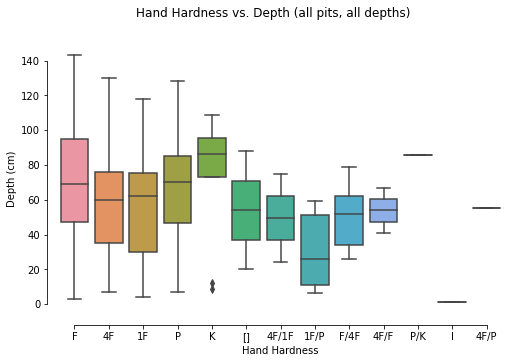

In [160]:
#createa a figure axis
fig, ax = plt.subplots(1, figsize=(8, 5), sharey=True)
fig.suptitle('Hand Hardness vs. Depth (all pits, all depths)')
sns.boxplot(x="hhardness", y="depth",
            data=hhardness_filter_df)
ax.set_xlabel('Hand Hardness')
ax.set_ylabel('Depth (cm)')
sns.despine(offset=10, trim=True)
#fig.savefig('/home/jovyan/snow-sinking/density_files/tree_depth_fig.png',dpi = 200)

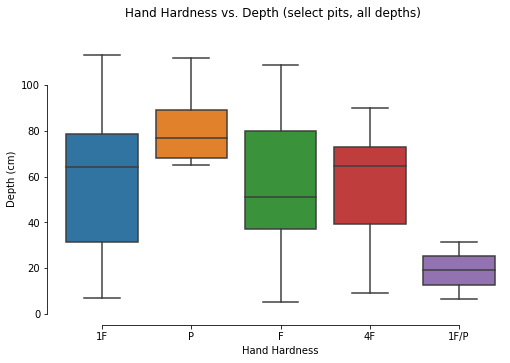

In [162]:
#createa a figure axis
fig, ax = plt.subplots(1, figsize=(8, 5), sharey=True)
fig.suptitle('Hand Hardness vs. Depth (select pits, all depths)')
sns.boxplot(x="hhardness", y="depth",
            data=hhardness_filSites_df)
ax.set_xlabel('Hand Hardness')
ax.set_ylabel('Depth (cm)')
sns.despine(offset=10, trim=True)
#fig.savefig('/home/jovyan/snow-sinking/density_files/tree_depth_fig.png',dpi = 200)

plot smb vs. depth and line for each site in different colors

3 box plots, all tree have same horizontal of tree canopy, vertical would be median, top 10, top 50 

In [ ]:
# density_groupSite_df = merged_df.groupby('site_id').agg({'value': ['mean', 'min', 'max']})
# density_groupSite_df = merged_df.groupby('site_id').agg({'depth': ['max']})